In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/comb_PM25_wind_Hanoi_2018_v3.csv")

In [3]:
df.head()

,DATE,PM2.5,T2MDEW,T2M,PS,TQV,TQL,H1000,DISPH,FRCAN,HLML,RHOA,CIG,WS,CLDCR,v_2m,v_50m,v_850
0,2018-01-01 01:00:00,69.2,10.79443,13.64376,100865.09,34.909637,0.009235,160.25461,0.256226,1.000000,63.907425,1.216159,NaN,NaN,NaN,0.429060,0.979452,6.175777
1,2018-01-01 02:00:00,75.5,10.72836,13.33932,100819.56,35.195385,0.006260,156.44829,0.256226,1.000000,63.832478,1.217125,NaN,NaN,NaN,0.383400,0.872296,5.997708
2,2018-01-01 03:00:00,90.2,10.60630,13.09753,100793.71,35.590984,0.003489,154.54437,0.256104,0.993164,63.766266,1.218085,NaN,NaN,NaN,0.339189,0.729687,5.915825
3,2018-01-01 04:00:00,97.6,10.50967,12.81360,100791.80,35.827934,0.002314,154.16837,0.255981,0.927490,63.718185,1.218972,NaN,NaN,NaN,0.305853,0.666341,5.885087
4,2018-01-01 05:00:00,89.1,10.49365,12.71010,100808.45,35.953880,0.001480,155.72943,0.255859,0.786133,63.684280,1.219831,NaN,NaN,NaN,0.258492,0.541109,5.796022


In [4]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")

In [5]:
pm = df["PM2.5"].values.reshape(-1, 1)

In [6]:
def plot_outliers(df, col, mask, title):
    plt.figure(figsize=(16,4))
    plt.plot(df.index, df[col], label='PM2.5')
    plt.scatter(df.index[mask], df[col][mask], s=80, color='red', label='outlier')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

## IQR method

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

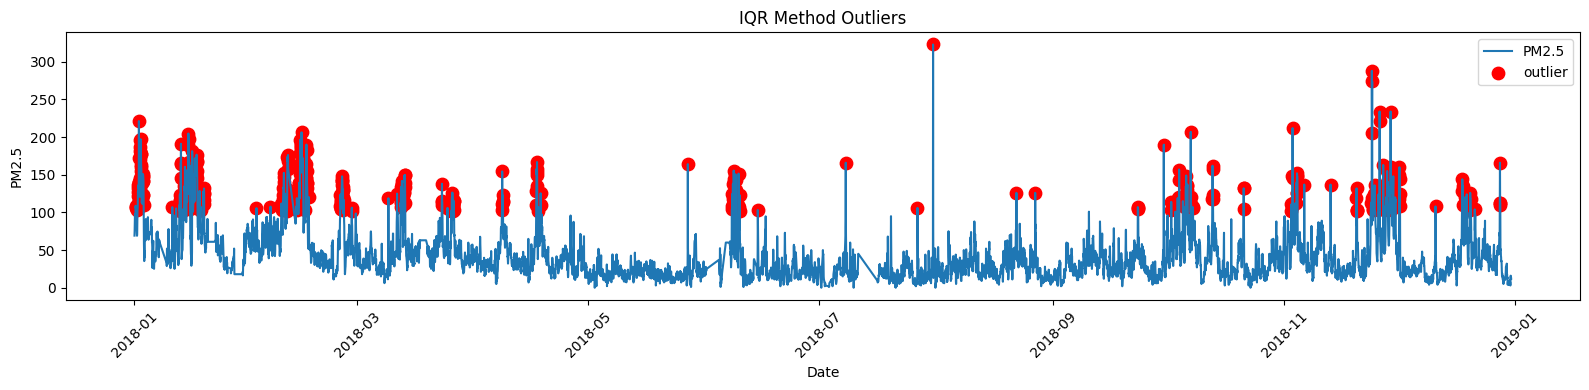

In [8]:
Q1, Q3 = df["PM2.5"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["IQR_outlier"] = (df["PM2.5"] < lower) | (df["PM2.5"] > upper)
plot_outliers(df, "PM2.5", df["IQR_outlier"], "IQR Method Outliers")

## Z-SCORE

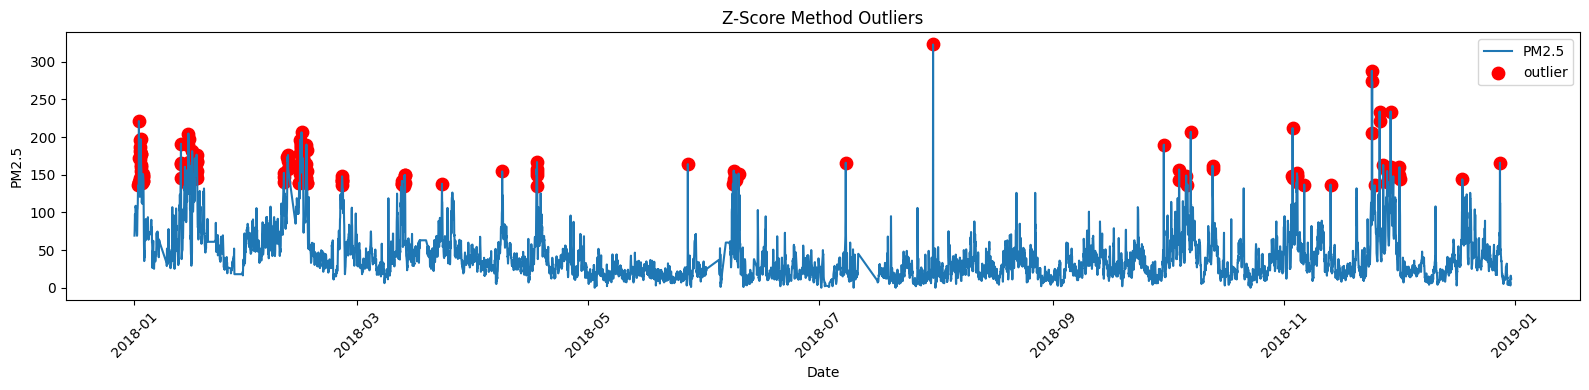

In [9]:
mean = df["PM2.5"].mean()
std = df["PM2.5"].std()

df["Z_outlier"] = np.abs((df["PM2.5"] - mean) / std) > 3
plot_outliers(df, "PM2.5", df["Z_outlier"], "Z-Score Method Outliers")

## MODIFIED Z-SCORE (MAD)

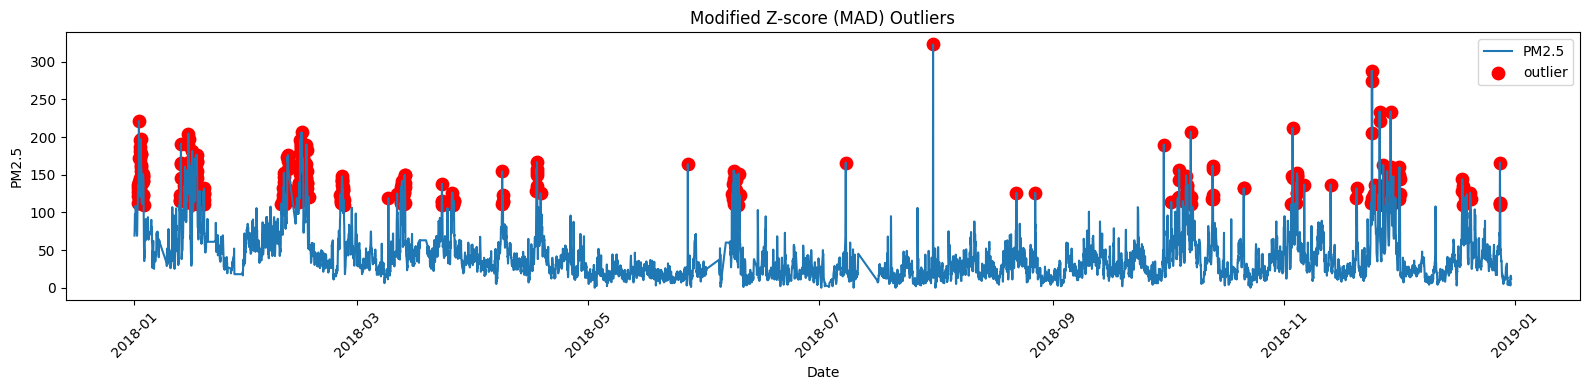

In [10]:
median = df["PM2.5"].median()
MAD = np.median(np.abs(df["PM2.5"] - median))

mod_z = 0.6745 * (df["PM2.5"] - median) / MAD
df["ModifiedZ_outlier"] = np.abs(mod_z) > 3.5

plot_outliers(df, "PM2.5", df["ModifiedZ_outlier"],
              "Modified Z-score (MAD) Outliers")

## ISOLATION FOREST

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN

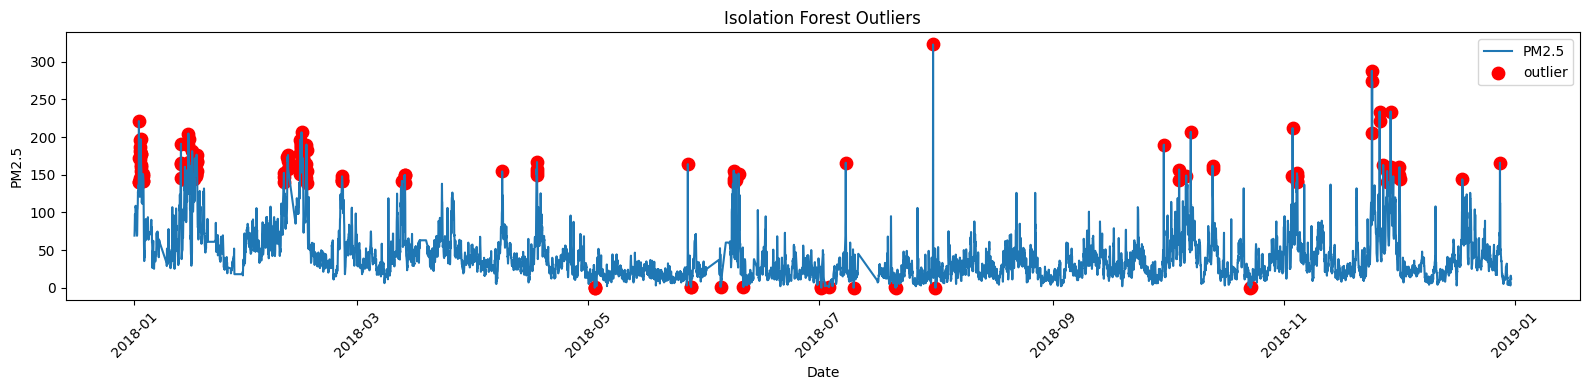

In [12]:
iso = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df["IsolationForest_outlier"] = iso.fit_predict(pm) == -1

plot_outliers(df, "PM2.5", df["IsolationForest_outlier"],
              "Isolation Forest Outliers")

## ELLIPTIC ENVELOPE

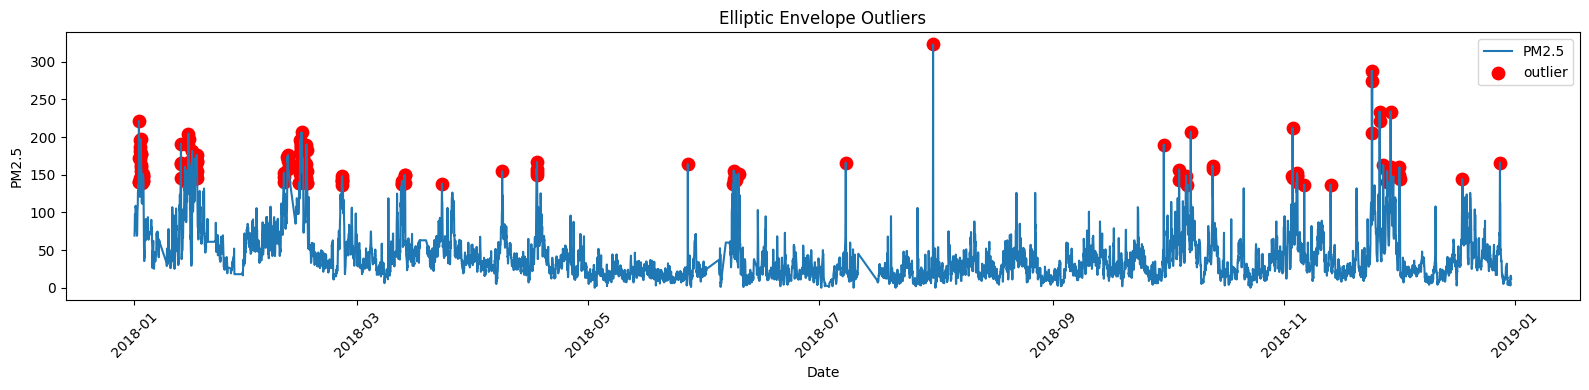

In [13]:
ellip = EllipticEnvelope(contamination=0.02)
df["EllipticEnvelope_outlier"] = ellip.fit_predict(pm) == -1

plot_outliers(df, "PM2.5", df["EllipticEnvelope_outlier"],
              "Elliptic Envelope Outliers")

## DBSCAN (density-based)

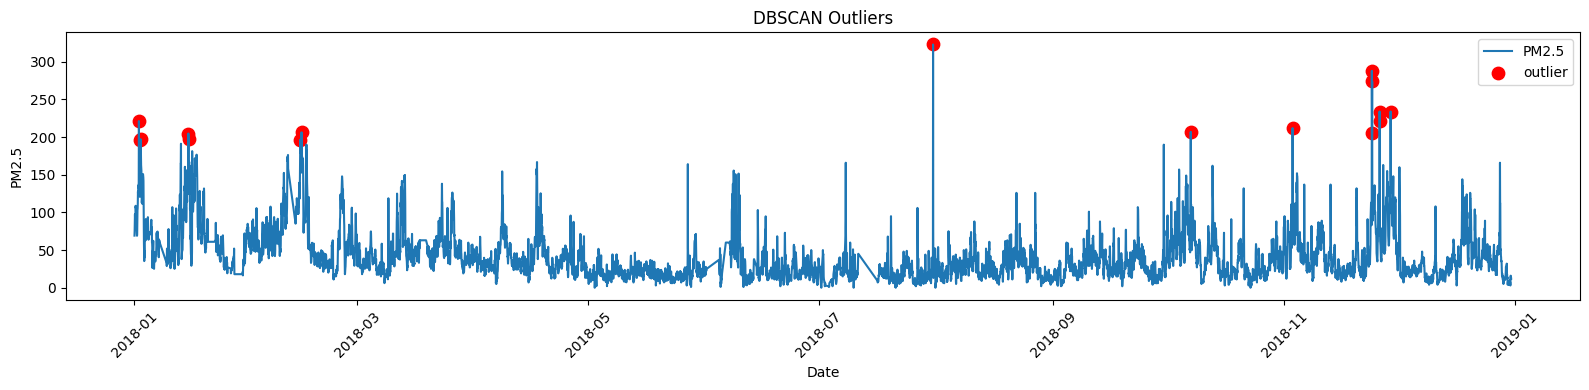

In [14]:
db = DBSCAN(eps=5, min_samples=10)
labels = db.fit_predict(pm)

# label -1 = noise (outlier)
df["DBSCAN_outlier"] = labels == -1

plot_outliers(df, "PM2.5", df["DBSCAN_outlier"], "DBSCAN Outliers")

## SUMMARY TABLE

In [15]:
print("\n=== Outlier counts by method ===")
print(df[[c for c in df.columns if "outlier" in c]].sum())

print("\n=== Detailed Outlier Table ===")
print(df)


=== Outlier counts by method ===
IQR_outlier                 478
Z_outlier                   168
ModifiedZ_outlier           373
IsolationForest_outlier     162
EllipticEnvelope_outlier    163
DBSCAN_outlier               16
dtype: int64

=== Detailed Outlier Table ===
                     PM2.5    T2MDEW       T2M          PS        TQV  \
DATE                                                                    
2018-01-01 01:00:00   69.2  10.79443  13.64376  100865.090  34.909637   
2018-01-01 02:00:00   75.5  10.72836  13.33932  100819.560  35.195385   
2018-01-01 03:00:00   90.2  10.60630  13.09753  100793.710  35.590984   
2018-01-01 04:00:00   97.6  10.50967  12.81360  100791.800  35.827934   
2018-01-01 05:00:00   89.1  10.49365  12.71010  100808.450  35.953880   
...                    ...       ...       ...         ...        ...   
2018-12-30 20:00:00   11.0   5.90347   7.10410  101968.250  30.307730   
2018-12-30 21:00:00   16.0   5.63010   6.95840  101950.440  29.222218   

In [16]:
df.to_csv("data/comb_PM25_outlier_detected.csv")